# **Sampling from the Solution Space of Genome-Scale Metabolic Models**

By [Haris Zafeiropoulos](https://hariszaf.github.io/) and [Daniel Rios Garza](https://danielriosgarza.github.io/) -- July, 2024

This notebook accompanies our chapter on the *“Flux Balance Analysis”* book, to be published in the protocol series Methods in Molecular Biology, by Springer Nature.

## **Setting working space**

You can either launch a Codespace based on this repository or run the project locally on your machine.

* **codespace**: Quick and easy to get started. Ideal for initial exploration, but may limit your ability to run custom experiments later on.

* **local**: Requires some setup and may involve troubleshooting environment issues, but gives you full control. Recommended if you plan to use your own data or customize the workflow later.



Here is how to go for each of those two cases.

### **Build a codespace**

To fire a codespace, you will need a GitHub account and then from our [GitHub repo](https://github.com/hariszaf/metabolic_toy_model/tree/sampling), use the `sampling` branch to create your codespace.

* First, click on the arrow on the `Code` button
* then, click on `Codespaces`
* and on the three dots `...`, to create a `New with options...`

![](files/figs/codespace-fire.png)

After you make sure you have the configuration as in the following picture, you may fire your codespace by clicking on the `Create codespace` button:

![](./files/figs/codespace-conf.png)

> **Advanced Tip**
>
> The [`devcontainer.json`](.devcontainer/devcontainer.json) describes the configuration of the codespace to be built. 
> 
> If you pay close attention, you will realise what you would need to make sure for your local build (see next paragraph).

### **Creating a Conda environment**

Here, we assume you have Miniconda or Anaconda installed in your machine. 

If you don't, you can follow [this tutorial](https://eduand-alvarez.medium.com/setting-up-anaconda-on-your-windows-pc-6e39800c1afb).

1. Create a Conda environment using Python 3.10 and a name of your choice; in this example, we'll call our environment `sampling`:

```conda create -n sampling -y python=3.10```

2) Activate your environment


```conda activate sampling```

3. We will be using `dingo` for flux sampling on the solution space of a metabolic model. `dingo` requires `PySPQR`; a module that wraps the [SuiteSparseQR](https://people.engr.tamu.edu/davis/suitesparse.html) decomposition function, but comes with a bunch of hard dependencies, based on your operating system. See [here](https://github.com/yig/PySPQR?tab=readme-ov-file#installation) for more. In the following, we assume you are working on Linux and that you have `sudo` rights:

```
sudo apt-get update -y
sudo apt-get install -y libsuitesparse-dev
```

4. You can now install the Python libraries required:

```pip install -r requirements.txt```

You may need the `--user` flag for this step:

```pip install -r requirements.txt --user```

5. You are now ready to go for it! 

In case you are working on VS Code or any other IDLE, make sure to set the kernel of the notebook to the `conda` environment you just built.

For example, if using VS Code, when you will try to run the first chunk of code, you will get a message like this:

![](./files/figs/select_kernel.png)

Then, you can click `Select Another Kernel... > Python Environments...` and you should look for the name of the environment you gave earlier, in our case `sampling`.

However, it's quite possible that IDLE will recognize the new environment after you close and relaunch it. 

## **Intro**

### **Bio**

We assume the reader/user is already familiar with the basic concepts of metabolic modeling and the basics of the `cobrapy` library. 

If this is not the case, you may **first** go through our according material on [this branch](), we were able to come up with for the 
needs of the [METABOLIC MODELS APPLIED TO MICROBIOMES](https://metabolicmodelingantony2025.onrender.com/) workshop.



As throughout this repository, we use metabolic models from three human gut-associated strains that are known for:

* occupying key ecological niches in the gut, and

* engaging in metabolic interactions with one another, as illustrated in the diagram below:



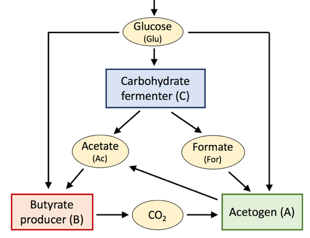

These ecological niches are based on the metabolism of the following three species:

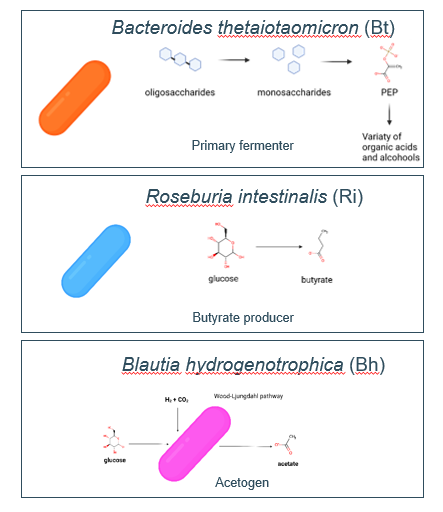

We will run our single-species sampling scenarios using an AGORA model for Bt and only in the community case we will use all three of them. 

### **Technical**

In case your Jupyter notebook does not line with the `sampling` environment, you may give it a shot after running:

In [2]:
import os
import sys

In [ ]:
env_site_packages = os.path.join(os.getenv('CONDA_PREFIX'), 'lib/python3.10/site-packages')  # Adjust for your Python version
if env_site_packages not in sys.path:
    sys.path.append(env_site_packages)

By now, you should be able to load the libraries required for this notebook:

In [1]:
# General
import numpy as np
import pandas as pd 
from pathlib import Path

# Sampling
import cobra
from cobra.sampling import ACHRSampler, OptGPSampler
import dingo_walk as dingo

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Local scripts
from scripts.utils import apply_environment
from scripts import mambo

Now you are good to keep track of the models to be used. 

In [3]:
cwd = Path(".").absolute()

agora_models_path = cwd / "files" / "models" / "AGORA"

bt_agora_filename = "Bacteroides_thetaiotaomicron_3731.xml"
bh_agora_filename = "Blautia_hydrogenotrophica_DSM_10507.xml"
ri_agora_filename = "Roseburia_intestinalis_L1_82.xml"


And decide on what **solver** you will be using. 

To solve the optimization problems in our model, a solver is required; special software that can solve a wide range of problem types, such as linear programming, mixed-integer linear programming, quadratic programming, mixed-integer quadratic programming etc.

These problems are rather common in metabolic modelling and most of the analyses performed in the field, are based on solving such optimization problems.

Let's see an example when loading a model with `cobra`:

In [4]:
bt_model = cobra.io.read_sbml_model(agora_models_path / bt_agora_filename)
bt_model.solver

In case Gurobi for example was available, `cobra` would prefer it and you would seed something like: 
```
>>> bt_model.solver
<optlang.gurobi_interface.Model object at 0x7da11588e9c0>
```

To check what solvers are available on your **environment**, you may run:

In [3]:
import optlang
print(optlang.available_solvers)

{'GUROBI': False, 'GLPK': True, 'MOSEK': False, 'CPLEX': False, 'COINOR_CBC': True, 'SCIPY': True, 'OSQP': True, 'HIGHS': True}


> You can think of Optlang as the SQLAlchemy of optimization
>
> SQLAlchemy isn't a database, but lets you talk to different databases using a unified interface.
>
> Optlang isn't a solver, but lets you talk to different solvers in a unified way.


Latest versions of `cobra` use [`optlang`](https://optlang.readthedocs.io/en/latest/) to describe their linear programs, which works as an interface to a series of solvers that may be available on your computing environment, e.g. GLPK, Gurobi etc. 

[Gurobi](https://www.gurobi.com) requires a paid license, but can also [be obtained](https://www.gurobi.com/downloads/) for free under an [academic license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/). [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio) too. 

On the other hand,[`glpk`](https://www.gnu.org/software/glpk/), [HIGHS](https://ergo-code.github.io/HiGHS/dev/) and others are open source and free. 

`dingo` uses HIGHS as its default solver; `highspy` should already been installed on your environment. 
You can always use the `glpk` instead, but would take considerably longer in Genome Scale models.

Thanks to HIGHS, `dingo` besides `glpk` supports: 

- `highs` 
- `gurobi`
- `copt`
- `mosek`

## **Sampling vs Flux Balance Analysis (FBA)**

We will go through the solution of the $Bt$ model, using its original medium, to have some first insight of what the model is suggesting 

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.


In [5]:
bt_model.compartments

{'c': 'Cytoplasm', 'e': 'Extracellular', 'p': 'Periplasm'}

In [14]:
init_sol = bt_model.optimize()

print(init_sol.objective_value)
print("--")
print(init_sol.fluxes)

75.49258411251671
--
12DGR180tex          2.593049
12DGR180tipp         2.593049
12PPD_Stex        -768.310259
12PPDtpp          -768.310259
23DHMPO            -25.601558
                     ...     
r2137pp              0.599388
rtranscription      75.492584
sink_PGPm1[c]        0.409026
sink_gthrd(c)     1000.000000
bio1                75.492584
Name: fluxes, Length: 1505, dtype: float64


In [15]:
bt_init_sum = bt_model.summary()
bt_init_sum.uptake_flux.sort_values("flux")

,flux,reaction,metabolite
EX_26dap_M(e),0.136347,EX_26dap_M(e),26dap_M[e]
EX_hspg_degr_2(e),0.599388,EX_hspg_degr_2(e),hspg_degr_2[e]
EX_cit(e),0.599388,EX_cit(e),cit[e]
EX_cl(e),0.599388,EX_cl(e),cl[e]
EX_mn2(e),0.599388,EX_mn2(e),mn2[e]
EX_mg2(e),0.599388,EX_mg2(e),mg2[e]
EX_cobalt2(e),0.599388,EX_cobalt2(e),cobalt2[e]
EX_cu2(e),0.599388,EX_cu2(e),cu2[e]
EX_pheme(e),0.599388,EX_pheme(e),pheme[e]
EX_ca2(e),0.599388,EX_ca2(e),ca2[e]


In [16]:
bt_init_sum.secretion_flux[bt_init_sum.secretion_flux["flux"] != 0]

,flux,reaction,metabolite
DM_4HBA,-0.599388,DM_4HBA,4hba[c]
DM_GCALD,-1.798165,DM_GCALD,gcald[c]
EX_12ppd_S(e),-768.310259,EX_12ppd_S(e),12ppd_S[e]
EX_ac(e),-1000.000000,EX_ac(e),ac[e]
EX_adn(e),-3.596331,EX_adn(e),adn[e]
EX_ala_L(e),-1000.000000,EX_ala_L(e),ala_L[e]
EX_biomass(e),-75.492584,EX_biomass(e),biomass[c]
EX_bz(e),-160.592648,EX_bz(e),bz[e]
EX_co2(e),-1000.000000,EX_co2(e),co2[e]
EX_dcyt(e),-21.098155,EX_dcyt(e),dcyt[e]


In [150]:
eps = 1e-6  # Small threshold to ignore negligible fluxes
carbon_sources = ["lac_D[c]", "fuc_L[c]"]

for csource in carbon_sources:
    met = bt_model.metabolites.get_by_id(csource)
    for rxn in met.reactions:
        v = sol.fluxes[rxn.id]
        # Skip reactions with near-zero flux
        if abs(v) < eps:
            continue
        # Determine if the metabolite is being produced or consumed
        if v > 0:
            if met in rxn.reactants:
                direction = "consuming"
            else:
                direction = "producing"
        else:  # v < 0
            if met in rxn.reactants:
                direction = "producing"
            else:
                direction = "consuming"

        # Print with metabolite and reaction information
        print(
            f"{rxn.id} {direction} {met.name} ~ {rxn.build_reaction_string()} || "
            f"{rxn.build_reaction_string(use_metabolite_names=True)} *** v = {v:.6f}"
        )
    print("-----")

D_LACt2pp producing D-lactate ~ h[p] + lac_D[p] <=> h[c] + lac_D[c] || proton + D-lactate <=> proton + D-lactate *** v = 787.770272
LDH_D consuming D-lactate ~ lac_D[c] + nad[c] <=> h[c] + nadh[c] + pyr[c] || D-lactate + Nicotinamide adenine dinucleotide <=> proton + Nicotinamide adenine dinucleotide - reduced + Pyruvate *** v = 328.731311
LDH_D2 consuming D-lactate ~ lac_D[c] + q8[c] --> pyr[c] + q8h2[c] || D-lactate + Ubiquinone-8 --> Pyruvate + Ubiquinol-8 *** v = 459.038960
-----
FCI consuming L-fucose ~ fuc_L[c] <=> fcl_L[c] || L-fucose <=> L-fuculose *** v = 768.999042
FUCt2_1pp producing L-fucose ~ 2.0 fuc_L[p] + h[p] <=> 2.0 fuc_L[c] + h[c] || 2.0 L-fucose + proton <=> 2.0 L-fucose + proton *** v = 384.499521
-----


When we removed the compounds that are not in the cytosol from the medium, we already observe a decrease biomass and 
also, that fucose is now among the uptake reactions with a flux.


[here is why](https://pubmed.ncbi.nlm.nih.gov/6421801/)



## **Sampling on the flux space of a Genome Scale Model**

We will use the following samplers for a set of different sampling experiments:

| sampler | experiment description | 
|:-------:|:----------------------:|
| `dingo` | s | 
| `ACHR`  | s | 
| `OptGPSampler` |s | 



In [ ]:
def sample_with_generate_ss(model, ESS=2000, PSRF=True):
    sampler       = dingo.PolytopeSampler(model)
    samples_ss    = sampler.generate_steady_states(ess=ESS, psrf = PSRF)
    samples_ss_df = pd.DataFrame.from_records(samples_ss, index = model.reactions)
    return samples_ss, samples_ss_df

In [17]:
def plot_hist(samples_df, rxn_id):
    data = samples_df.loc[rxn_id]
    sns.histplot(data, bins=20, kde=False)
    plt.show()


In [7]:
# dingo biased 
bt_dmodel = dingo.MetabolicNetwork.from_sbml((agora_models_path / bt_agora_filename).as_posix())
bt_dmodel.set_solver = "highs"

In [ ]:
bt_opt_biom_ss, bt_opt_biom_ss_df = sample_with_generate_ss(bt_dmodel, ESS=1000, PSRF=False)

In [ ]:
bt_opt_biom_ss_df
# bt_dmodel._parameters

In [7]:
# SOS. OptGp for 1000 points on Bt -- cobra implementation
bt_optgp_sampler = OptGPSampler(bt_model, processes=4)
# by default, OptGPSampler has a thinning of 100

bt_optgp_samples = bt_optgp_sampler.sample(1000)

In [13]:
bt_optgp_samples["bio1"]

0      8.831565
1      8.557346
2      8.563392
3      8.538595
4      8.541057
        ...    
95    24.663606
96    26.410472
97    27.268859
98    24.728103
99    24.867983
Name: bio1, Length: 100, dtype: float64

In [21]:
bt_optgp_sampler.

AttributeError: 'OptGPSampler' object has no attribute '__attribute__'

### **Unbiased sampling**

In [183]:
# Load model as dingo model
ecoli_dmodel = dingo.MetabolicNetwork.from_sbml((cwd / "files/models/e_coli_core.xml").as_posix())

# Fire sampling using generate_steady_states() on initial model - biased since objective function is pointing to the biomass pseudo-reaction
ecoli_samples_ss, ecoli_samples_ss_df = sample_with_generate_ss(ecoli_dmodel)

In [186]:
ecoli_dmodel.reactions.index("BIOMASS_Ecoli_core_w_GAM")

24

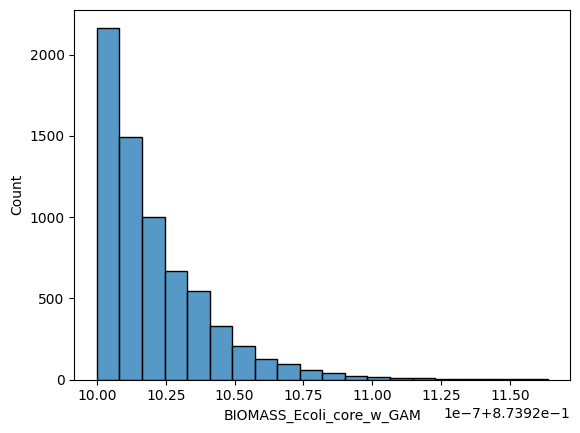

In [224]:
# Plot histogram
data = ecoli_samples_ss_df.loc["BIOMASS_Ecoli_core_w_GAM"]
sns.histplot(data, bins=20, kde=False)
plt.show()

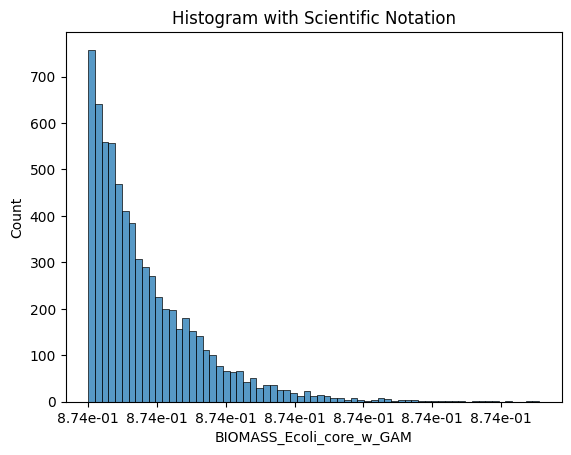

In [217]:
import matplotlib.ticker as ticker
data = ecoli_samples_ss_df.loc["BIOMASS_Ecoli_core_w_GAM"]
ax = sns.histplot(data)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
plt.title("Histogram with Scientific Notation")
plt.show()

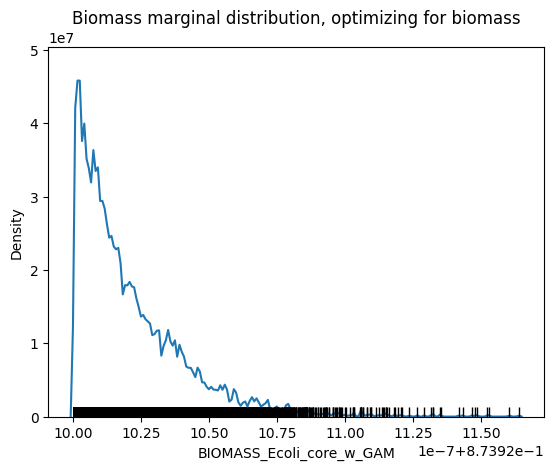

In [231]:
sns.kdeplot(data, bw_adjust=0.1)
sns.rugplot(data, color="black")
plt.title("Biomass marginal distribution, optimizing for biomass")
plt.show()

Biomass value is actually fixed, as supposed to. 

In [ ]:
EX_fru

Unbiased sampling with `dingo`

We need to shut down the objective function. 


In [199]:
ecoli_dmodel_no_obj =  dingo.MetabolicNetwork.from_sbml((cwd / "files/models/e_coli_core.xml").as_posix())
ecoli_dmodel_no_obj.objective_function = np.zeros(len(ecoli_dmodel_no_obj.reactions))

In [ ]:
ecoli_samples_no_obj, ecoli_samples_no_obj_df  = sample_with_generate_ss(ecoli_dmodel_no_obj)

In [204]:
ecoli_samples_no_obj_df.loc["BIOMASS_Ecoli_core_w_GAM"]

0       0.015705
1       0.056381
2       0.009537
3       0.097653
4       0.070184
          ...   
5195    0.017433
5196    0.026358
5197    0.044019
5198    0.025051
5199    0.085501
Name: BIOMASS_Ecoli_core_w_GAM, Length: 5200, dtype: float64

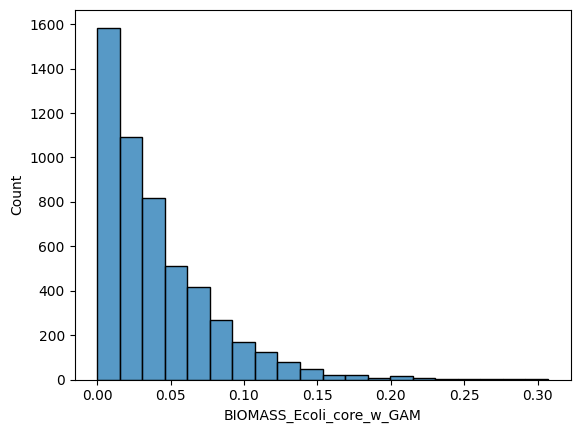

In [206]:
# Plot histogram
sns.histplot(ecoli_samples_no_obj_df.loc["BIOMASS_Ecoli_core_w_GAM"], bins=20, kde=False)
plt.show()

In [134]:
sol.fluxes[sol.fluxes.index == "EX_fuc_L(e)"]
# v = sol.fluxes[rxn.id]

EX_fuc_L(e)    0.0
Name: fluxes, dtype: float64

Lactate comes into the cell from the in silico environment, it passes through the periplasm and then it converts to pyruvate! 

### ad

In [138]:
medium_compounds = []
not_in_cytosol   = []
for ex, bound in bt_cobra.medium.items(): 
    ex1 = ex.strip("(e)")
    ex1 = ex1.strip("EX_")
    try: 
        m = bt_cobra.metabolites.get_by_id(ex1 + "[c]")
        medium_compounds.append((m.name, m.id))
    except:
        not_in_cytosol.append(ex)
        pass

In [139]:
print(
    "medium_compounds: ", len(medium_compounds), 
    "not_in_cytosol: ", len(not_in_cytosol),
    "overall: ", len(bt_cobra.medium)
)

medium_compounds:  115 not_in_cytosol:  86 overall:  201


In [15]:
bt_cobra.metabolites.get_by_id("fru[c]")

Metabolite identifier,fru[c]
Name,D-Fructose
Memory address,0x78bc316fc160
Formula,C6H12O6
Compartment,c
In 7 reaction(s),"SBTD_D2, XYLI2, FRUASE1, FRUt2rpp, SUCR, PSICSE, HEX7"


In [86]:
bt_cobra.metabolites.get_by_id("lac_D[c]")

Metabolite identifier,lac_D[c]
Name,D-lactate
Memory address,0x78bc31b62f80
Formula,C3H5O3
Compartment,c
In 4 reaction(s),"LDH_D2, LDH_D, D_LACt2pp, D_LACD"


It also secretes: acetate, alanine, h2, nh4, serine, succinate.

In [140]:
trunc_medium = bt_cobra.medium.copy()
for i in not_in_cytosol:
    del trunc_medium[i]
len(trunc_medium)

115

In [143]:
bt_cobra.medium  = trunc_medium
bt_trunc_summary = bt_cobra.summary()
sol_trunc        = bt_cobra.optimize()

In [144]:
bt_trunc_summary.uptake_flux.sort_values("flux")

,flux,reaction,metabolite
EX_26dap_M(e),0.107536,EX_26dap_M(e),26dap_M[e]
EX_cl(e),0.472734,EX_cl(e),cl[e]
EX_cobalt2(e),0.472734,EX_cobalt2(e),cobalt2[e]
EX_zn2(e),0.472734,EX_zn2(e),zn2[e]
EX_mn2(e),0.472734,EX_mn2(e),mn2[e]
EX_mg2(e),0.472734,EX_mg2(e),mg2[e]
EX_k(e),0.472734,EX_k(e),k[e]
EX_fe3(e),0.472734,EX_fe3(e),fe3[e]
EX_ptrc(e),0.472734,EX_ptrc(e),ptrc[e]
EX_so4(e),0.472734,EX_so4(e),so4[e]


##Sampling the solution space of metabolic models

While FBA finds a single maximum for the objective function, one might be interested in the space of viable metabolisms. This space reveals the range of conditions where the cell could live without the assumption of maximizing an objective function.

The space of viable metabolisms is explored by taking uniform samples from the flux distribution. Besides revealing the cell's metabolic potential, these samples also reveal the conformations of higher likelihood and the burden of regulation needed for the cell to achieve its "maximum growth". In the example below, we compare the point of optimal growth with alternative flux distributions.

In [ ]:
# import the necessary packages and functions


#for making the plots
import matplotlib.pyplot as plt
# plt.style.use('seaborn-bright')


**step 2** : load the model, apply the rich media

In [ ]:
model_sf = cobra.io.read_sbml_model(os.path.join(modelFolder,'sugar_fermenter_toy_model.xml' ))


print("Initia medium:", model_sf.medium)
print("Total potential exchange reactions:", model_sf.exchanges)

rich_media = {'EX_cpd00027_e':10,
         'EX_cpd00036_e':10,
         'EX_cpd00159_e':10,
         'EX_cpd00047_e':10,
         'EX_cpd00029_e':10,
         'EX_cpd00067_e':10
         }

apply_environment(model_sf, rich_media)
print(model_sf.medium)

**step 3**: perform sampling

In [ ]:
sol = model_sf.optimize()
z = sol.objective_value #the objective value

#reaction fluxes under the optimal solution
glycolysis = model_sf.reactions.rxn00459.flux
fp = model_sf.reactions.EX_cpd00047_e.flux #formate production
lp = model_sf.reactions.EX_cpd00159_e.flux #lactate production
sp = model_sf.reactions.EX_cpd00036_e.flux #succinate production

achr = ACHRSampler(model_sf, thinning=10) #see https://cobrapy.readthedocs.io/en/latest/sampling.html
s1 = achr.sample(5000) #samples
v = achr.validate(s1)
sample = s1[v=='v'] #keep only the feasible samples

**step 4**: make plots

In [ ]:
fig, ax = plt.subplots()

#sampled biomass vs the sampled glycolysis
ax.scatter(sample.biomass, sample.rxn00459, s=0.1, color='#add8e6', alpha=0.5)

#optimal biomass vs the optimal glycolysis
ax.scatter(sol.objective_value, glycolysis, s=80, color='#add8e6', label = 'Glycolysis', edgecolors='k')

#sampled biomass vs the sampled formate production
ax.scatter(sample.biomass, sample.EX_cpd00047_e, s=0.1, color='purple', alpha=0.5)

#optimal biomass vs the optimal formate production
ax.scatter(sol.objective_value, fp, s=80, color='purple', label = 'Formate prod', edgecolors='k')

#sampled biomass vs the sampled succinate production
ax.scatter(sample.biomass, sample.EX_cpd00036_e, s=0.1, color='orange', alpha=0.5)

#optimal biomass vs the optimal succinate production
ax.scatter(sol.objective_value, sp, s=80, color='orange', label = 'Succinate prod', edgecolors='k')

#sampled biomass vs the sampled lactate production
ax.scatter(sample.biomass, sample.EX_cpd00159_e, s=0.1, color='#00ff9f', alpha=0.5)

#optimal biomass vs the optimal lactate production
ax.scatter(sol.objective_value, lp, s=80, color='#00ff9f', label = 'Lactate prod', edgecolors='k')

ax.set_ylabel('Flux', fontsize=14)
ax.set_xlabel('Biomass flux', fontsize=14)
plt.legend(fontsize='large', fancybox=True, title='Carb. Ferm.', title_fontsize='x-large', loc=2)
plt.xlim(0,z+1)



#### Changing the environment

The metabolites are made available to the models through the exchange reactions (see above).

To 'control' the composition, set the lower bound. But take into account that these are constrained-based models. To 'force' the models to consume a defined amount, set the lower and upper bound to this amount (this often leads to unfeasible models)

In [ ]:
# provide a rich media
for i in model.exchanges:
    i.lower_bound = -1000

obj = model.optimize()

print('rich media: ', obj.objective_value, '\n')


# remove glucose
model.reactions.EX_cpd00027_e.lower_bound=0

obj = model.optimize()

print('no glucose: ', obj.objective_value, '\n')

# force a glucose flux

model.reactions.EX_cpd00027_e.lower_bound=-30
model.reactions.EX_cpd00027_e.upper_bound=-30
obj = model.optimize()

print('forced glucose flux: ', obj.objective_value, '\n')

print('glucose flux: ',
model.reactions.EX_cpd00027_e.flux)


In [ ]:
model.medium

### Model manipulation (Level 3)

- Generate random environment compositions and associate them to the production of biomass by the three toy models

- Compare their growth rate distributions across these random environments (making box plots should be enough)

- Make the same comparison without glucose

- **bonus task**: repeat the above in an environment with a fixed high and low sugar concentration.


AGORA models under `files/models/AGORA`:

- [*Bacteroides thetaiotaomicron* 3731](https://vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/Bacteroides_thetaiotaomicron_3731.xml)

- [*Blautia hydrogenotrophica* DSM 10507](https://vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/Blautia_hydrogenotrophica_DSM_10507.xml)

- [*Roseburia_intestinalis* L1 82](https://vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/Roseburia_intestinalis_L1_82.xml)



In [ ]:
import dingo_walk as dingo

# Blautia
bh_agora_model   = dingo.MetabolicNetwork.from_sbml("Blautia_hydrogenotrophica_DSM_10507.xml")
sampler          = dingo.PolytopeSampler(bh_agora_model)
bh_agora_samples = sampler.generate_steady_states()

# Bacteroides
bt_agora_model   = dingo.MetabolicNetwork.from_sbml("Bacteroides_thetaiotaomicron_3731.xml")
sampler          = dingo.PolytopeSampler(bt_agora_model)
bt_agora_samples = sampler.generate_steady_states()

# Roseburia
ri_agora_model   = dingo.MetabolicNetwork.from_sbml("Roseburia_intestinalis_L1_82.xml")
sampler          = dingo.PolytopeSampler(ri_agora_model)
ri_agora_samples = sampler.generate_steady_states()

> **Note**
>
> ***Fermentation*** and ***respiration*** are the two major processes aiming at
> generate ATP for cellular functions and for both the first step is glycolysis, i.e. the breakdown of glucose (or other sugars) into pyruvate.
> 
> Their key difference focuses on whether they involve an **Electron Transport Chain** (respiration) or not (fermentation).
> 
> Respiration, when aerobic, ends up producing $CO{_2}$ and $H{_2}0$, while fermentation organic acids (e.g. lactate) or alcohol (e.g., ethanol) and $CO_{2}$.
> Last, respiration can reach up to much higher ATP yield, i.e. ATP molecules per glucose.


## E. coli tests

In [25]:

#  (i) 'cdhr': Coordinate Directions Hit-and-Run, 
# (ii) 'rdhr': Random Directions Hit-and-Run, 
# (iii) 'billiard_walk', 
# (iv) 'ball_walk', 
# (v) 'dikin_walk', 
# (vi) 'john_walk', 
# (vii) 'vaidya_walk'.

ecoli = dingo.MetabolicNetwork.from_sbml( (cwd / "files/models/e_coli_core.xml").as_posix() )

ec_dingo_sampler = dingo.PolytopeSampler(ecoli)

ec_cdhr_samples = ec_dingo_sampler.generate_steady_states_no_multiphase(
    method      = 'cdhr',
    n           = 1000,
    burn_in     = 0,
    thinning    = 100,
    variance    = 1.0,
    bias_vector = None,
    ess         = 1000
)

In [28]:
bt = dingo.MetabolicNetwork.from_sbml( ( agora_models_path / bt_agora_filename ).as_posix() )
bt_dingo_sampler = dingo.PolytopeSampler(bt)

bt_cdhr_samples = bt_dingo_sampler.generate_steady_states_no_multiphase(
    method      = 'cdhr',
    n           = 1000,
    burn_in     = 0,
    thinning    = 100,
    variance    = 1.0,
    bias_vector = None,
    ess         = 1000
)

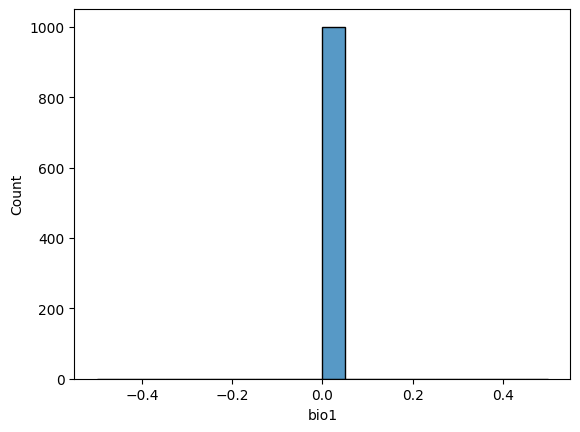

In [32]:
bt_cdhr_samples_df = pd.DataFrame.from_records(bt_cdhr_samples, index = bt.reactions)
plot_hist(bt_cdhr_samples_df, "bio1")

In [36]:
np.max(bt_cdhr_samples_df.loc["bio1"])

0.0

In [37]:
bt_cdhr_samples.shape

(1505, 1000)

In [38]:
len(bt.reactions)

1505

`cobra` implements:

- achr: Artificial Centering Hit-and-Run sampler.
- OptGP: Improved Artificial Centering Hit-and-Run sampler.